In [21]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd  ####  
import numpy as np #### 
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.stats.api as sms
import statsmodels.api as sm

El conjunto de datos conocido como “California Housing Dataset” puede ser cargado del
paquete sklearn. La variable objetivo es el valor medio de la vivienda para los distritos de
California, expresado en cientos de miles de dólares ($100000). Este conjunto de datos se derivó
del censo de EE.UU. de 1990, usando como unidad de censo el grupo de bloques. Un grupo de
bloques es la unidad geográfica más pequeña para la que La Oficina del Censo de EE.UU. publica
datos de muestra (un grupo de bloque generalmente tiene una población de 600 a 3000 personas).
Un hogar es un grupo de personas que residen dentro de una casa. Dado que el promedio. El
número de habitaciones y dormitorios en este conjunto de datos se proporciona por hogar, estas
columnas pueden tomar valores sorprendentemente grandes para grupos de bloques con pocos
hogares y muchas casas vacías, como centros vacacionales.

Lea el conjunto de datos usando la función fetch_california_housing del paquete
sklearn.datasets, guardelos en una variable llamada california_housing y con el comando
print(california_housing.DESCR) observe la descripción general del dataset y en
especial qué es cada una de las variables de entrada.

In [22]:
from sklearn.datasets import fetch_california_housing

In [23]:
california_housing = fetch_california_housing()

print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Separe las variables explicativas X de la variable respuesta Y, para acceder a ellas use los
comandos california_housing.data y california_housing.target. Considere la conveniencia de
incluir las variables Longitud y Latitud al modelo. Haga un análisis exploratorio de las
correlaciones entre las variables y comente al respecto.

In [24]:
dfY = pd.DataFrame(california_housing.target, columns=['ValorMedio'])
dfX = pd.DataFrame(california_housing.data,columns=california_housing.feature_names)

Debemos eliminar las variables Latitud y Longitud dado que estas deben analizarse de otra manera, con objetos tipo raster o vectores geograficos, lo cual no hace parte de nuestra pregunta ni informacion preliminar. 

In [25]:
dfX = dfX.drop(['Latitude','Longitude'], axis=1)

In [26]:
columnasX = dfX.columns.tolist()
columnasX

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

In [27]:
df = pd.concat([dfY, dfX], axis = 1)

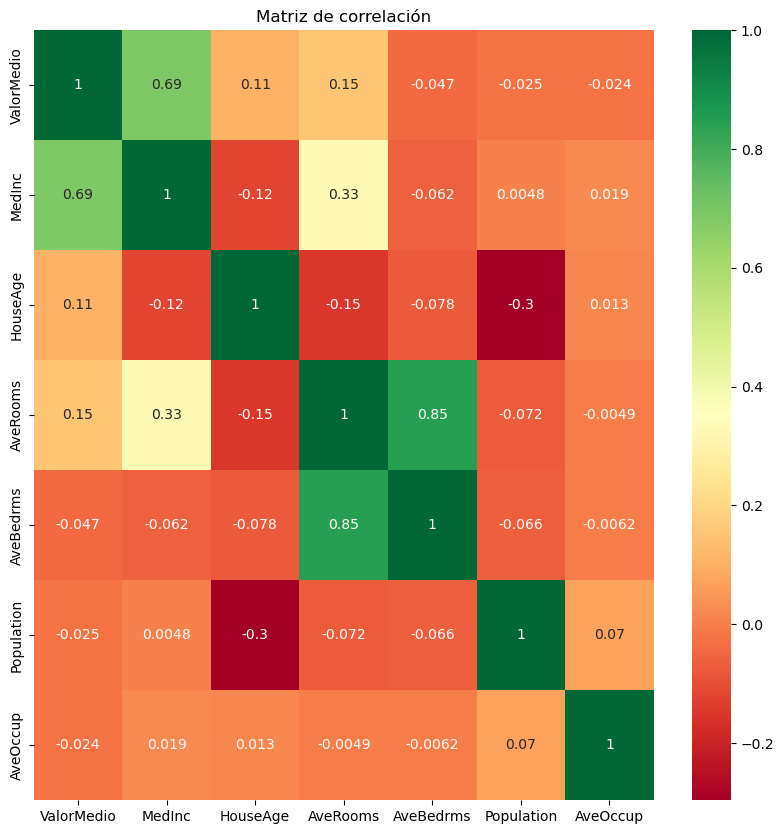

In [28]:

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(10,10))
sn.heatmap(corr_matrix, annot=True, cmap='RdYlGn')
plt.title('Matriz de correlación')
plt.show()

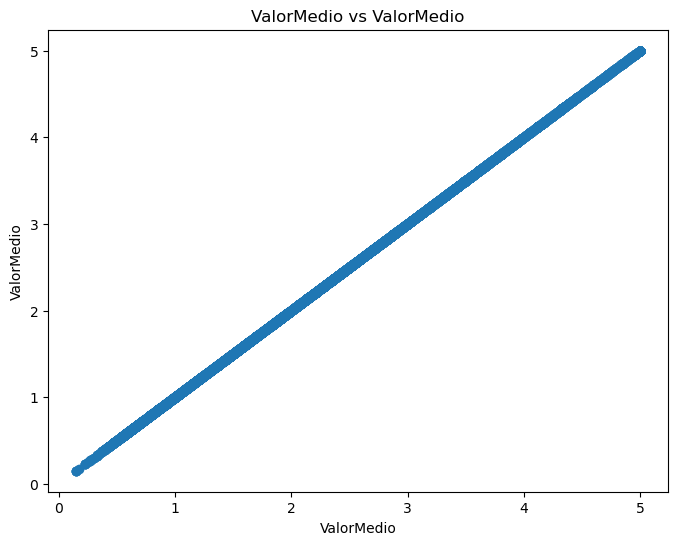

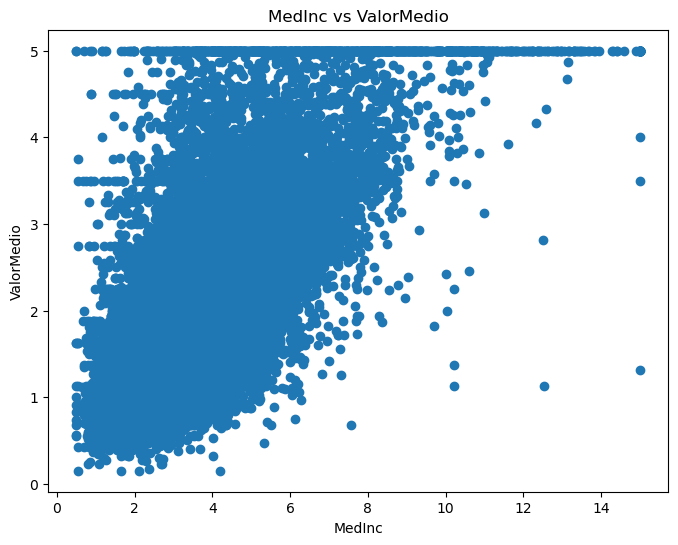

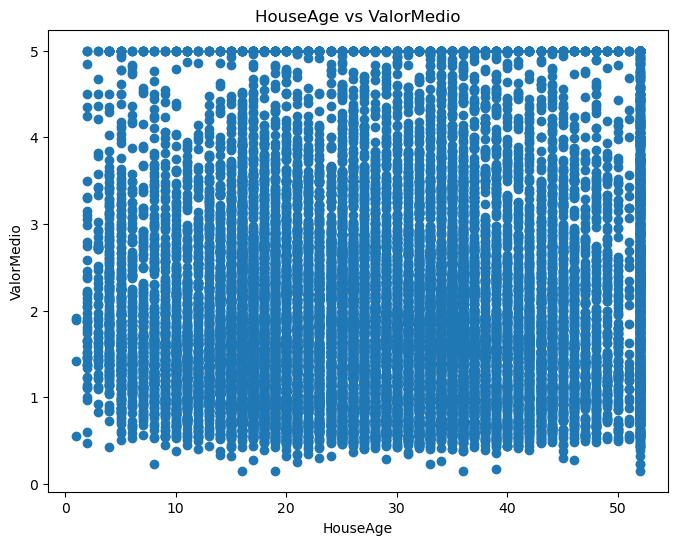

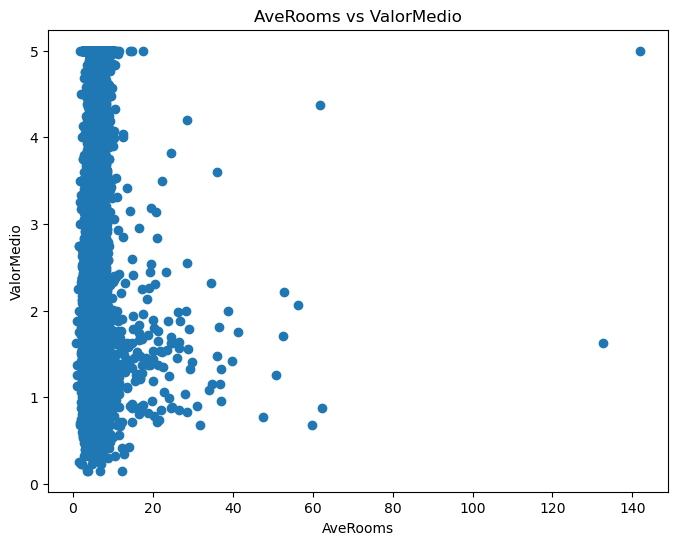

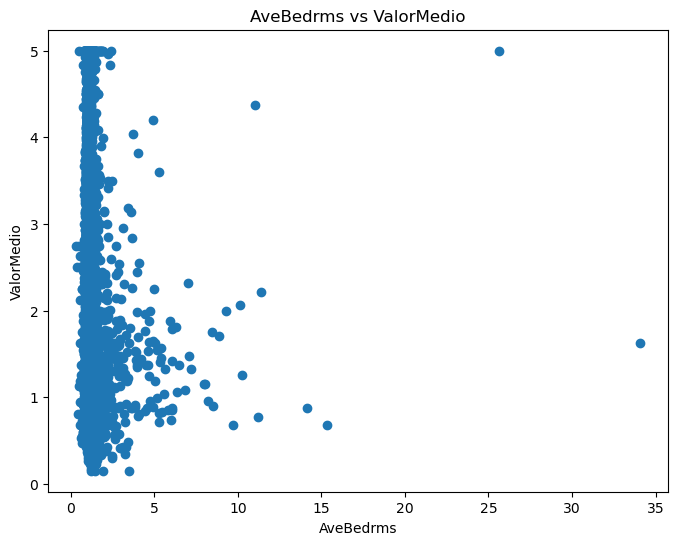

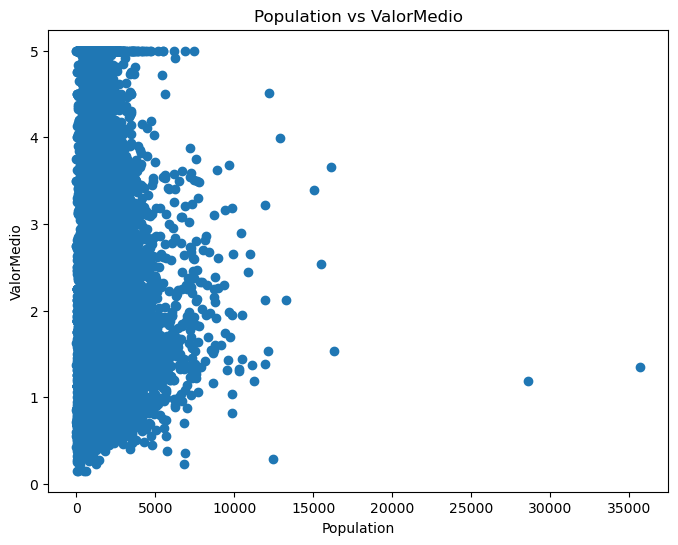

In [29]:
# Crear una gráfica individual para cada variable
for variable in df.columns[:-1]:  # Excluye la última columna ('MedInc')
    plt.figure(figsize=(8, 6))
    plt.scatter(df[variable], df['ValorMedio'])
    plt.xlabel(variable)
    plt.ylabel('ValorMedio')
    plt.title(f'{variable} vs ValorMedio')
    plt.show()

Ajuste un modelo de regresión LASSO con un coeficiente de penalización pequeño, iterativamente
ajuste este valor para eliminar variables explicativas y corregir el problema de
multicolinealidad, en cada iteración calcule las correlaciones de las variables explicativas y
pare cuando no se encuentren correlaciones altas.

In [30]:
La10 = Lasso(alpha=0.01)
La10.fit(dfX,dfY)

Lasso(alpha=0.01)

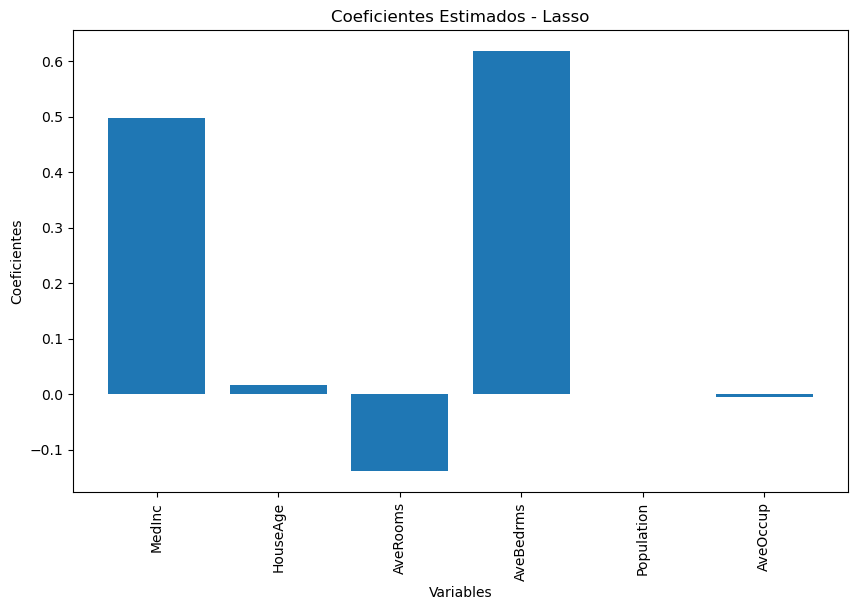

In [31]:
# Graficar los coeficientes estimados para Lasso
lasso_coefs = La10.coef_
# Obtener los nombres de las variables
feature_names = dfX.columns

# Graficar los coeficientes estimados para Lasso
plt.figure(figsize=(10, 6))
plt.bar(feature_names, lasso_coefs)
plt.xlabel('Variables')
plt.ylabel('Coeficientes')
plt.title('Coeficientes Estimados - Lasso')
plt.xticks(rotation=90)
plt.show()

In [32]:
### ['HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
dfXc = dfX.drop(['Population', 'AveOccup'], axis=1)

Ajuste un modelo de regresión OLS con las variables reducidas y revise los residuales.

In [ ]:
import statsmodels.api as sm
X = sm.add_constant(dfXc)
model = sm.OLS(dfY, X)
results = model.fit()
print(results.summary())

Realice una detección de atípicos usando la distancia de Mahalanobis, eliminelos y vuelva a
ajustar el modelo OLS, valide los supuestos del modelo. Quice hacerlo con una matriz de covarianza,pero entonces salio que la matriz era singular como se ve acontinuacion:

In [ ]:
cov_matrix = np.cov(X.T)  # Calcular la matriz de covarianza de X
inv_cov_matrix = np.linalg.inv(cov_matrix)  # Calcular la inversa de la matriz de covarianza

# Calcular la distancia de Mahalanobis para cada observación
mahalanobis_dist = []
for i in range(X.shape[0]):
    diff = X.iloc[i] - X.mean()
    dist = np.sqrt(diff.dot(inv_cov_matrix).dot(diff.T))
    mahalanobis_dist.append(dist)

Para abordar el problema de la matriz de covarianza singular y evitar el error "LinAlgError: Singular matrix", econtre que puedo usar un enfoque iterativo que elimine las variables altamente correlacionadas similar a como se pide en el punto. Realizando la eliminacion hasta que la matriz de covarianza sea no singular.

In [35]:
import statsmodels.api as sm

def remove_highly_correlated_variables(X):
    corr_matrix = X.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    highly_correlated_vars = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
    X_clean = X.drop(highly_correlated_vars, axis=1)
    return X_clean

def fit_ols_model(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results

# Iterative process to remove highly correlated variables
X_clean = dfXc.copy()
while True:
    try:
        cov_matrix = np.cov(X_clean.T)
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        break
    except np.linalg.LinAlgError:
        X_clean = remove_highly_correlated_variables(X_clean)

model_results = fit_ols_model(X_clean, dfY)
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:             ValorMedio   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     5995.
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        20:45:14   Log-Likelihood:                -24284.
No. Observations:               20640   AIC:                         4.858e+04
Df Residuals:                   20635   BIC:                         4.862e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3958      0.025    -16.012      0.0

Realice una detección de atípicos usando la distancia de Mahalanobis, eliminelos y vuelva a
ajustar el modelo OLS, valide los supuestos del modelo.

In [ ]:
from scipy.stats import chi2

In [34]:
def remove_highly_correlated_variables(X):
    corr_matrix = X.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    highly_correlated_vars = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
    X_clean = X.drop(highly_correlated_vars, axis=1)
    return X_clean

def fit_ols_model(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results

def mahalanobis_distance(X):
    cov_matrix = np.cov(X.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    mean_difference = X - X.mean(axis=0)
    mahalanobis = np.sqrt(np.einsum('ij,ij->i', np.dot(mean_difference, inv_cov_matrix), mean_difference))
    return mahalanobis

def detect_outliers(X, threshold):
    mahalanobis_dist = mahalanobis_distance(X)
    critical_value = chi2.ppf(1 - threshold, X.shape[1])
    outliers = mahalanobis_dist > critical_value
    return outliers

def remove_outliers(X, y, outliers):
    X_filtered = X[~outliers]
    y_filtered = y[~outliers]
    return X_filtered, y_filtered

# Iterative process to remove highly correlated variables
X_clean = dfXc.copy()
while True:
    try:
        cov_matrix = np.cov(X_clean.T)
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        break
    except np.linalg.LinAlgError:
        X_clean = remove_highly_correlated_variables(X_clean)

outliers = detect_outliers(X_clean, threshold=0.05)
X_filtered, y_filtered = remove_outliers(X_clean, dfY, outliers)
model_results = fit_ols_model(X_filtered, y_filtered)
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:             ValorMedio   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     6255.
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        20:45:02   Log-Likelihood:                -23982.
No. Observations:               20593   AIC:                         4.797e+04
Df Residuals:                   20588   BIC:                         4.801e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5274      0.036    -14.753      0.0